In [1]:
# Import Library
import pandas as pd
import numpy as np
import re
import string
import jellyfish
import sys
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Import NLTK
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DiffranNC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DiffranNC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Membaca dataframe ulasan tokopedia
df = pd.read_csv("Tokopedia Reviews.csv") [:2000] # membaca df dari 0-2000
df = df.rename(columns = {'content' : 'Reviews', 'label':'Sentiment'}) # mengganti nama df
df

,Reviews,Sentiment
0,mantap dah,positif
1,Ok,positif
2,Untuk saat ini Tokopedia bukan mengalami kemaj...,negatif
3,okelah,positif
4,great,positif
...,...,...
1995,siip mntab,positif
1996,Udah ga bisa gabung gratis ongkir sama cashbac...,negatif
1997,sangat puas,positif
1998,selama menggunakan Tokopedia tidak mengecewaka...,positif


In [3]:
# Membaca lexicon
lexicon  = pd.read_csv("Lexicon.csv")
lexicon

,slang,formal
0,woww,wow
1,aminn,amin
2,met,selamat
3,netaas,menetas
4,keberpa,keberapa
...,...,...
15001,gataunya,enggak taunya
15002,gtau,enggak tau
15003,gatau,enggak tau
15004,fans2,fan-fan


In [4]:
# Membaca kamus kbbi dan diubah menjadi data str
kbbi = pd.read_csv('kbbi.csv')
kbbi["kata"] = kbbi["kata"].astype(str)
kbbi

,kata
0,a
1,aa
2,ab
3,aba
4,aba-aba
...,...
72417,zuriah
72418,zuriat
72419,zus
72420,zusanli


In [5]:
# Preprocessing Casefolding, cleaning, dan emoji
def casefolding(text):
    text = text.lower()
    return text

def cleaning(text):
    #Hapus link
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    #Hapus @ akun
    text = re.sub(r"@[\w]*", "", text)  
    #Hapus angka
    text = re.sub(r"\d+", "", text)  
    #Hapus tanda baca
    text = re.sub(r'[^a-zA-z0-9]', ' ', text) 
    # remove mentions
    text = re.sub(r'@[A-Za-z0-9]+', '', text) 
    # remove hashtag
    text = re.sub(r'#[A-Za-z0-9]+', '', text) 
    # remove numbers
    text = re.sub(r'[0-9]+', '', text) 
    # Unescape HTML
    text = re.sub(r'<[^<]+?>', '', text)   
    # replace new line into space
    text = text.replace('\n', ' ') 
    # remove all punctuations
    text = text.translate(str.maketrans(' ', ' ', string.punctuation)) 
    # remove characters space from both left and right text
    text = text.strip(' ') 
    # remove stopwords
    #text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['Reviews'] = df['Reviews'].apply(casefolding)
df['Reviews'] = df['Reviews'].apply(remove_emoji)
df['Reviews'] = df['Reviews'].apply(cleaning)

df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df

,Reviews,Sentiment
0,mantap dah,positif
1,ok,positif
2,untuk saat ini tokopedia bukan mengalami kemaj...,negatif
3,okelah,positif
4,great,positif
...,...,...
1995,siip mntab,positif
1996,udah ga bisa gabung gratis ongkir sama cashbac...,negatif
1997,sangat puas,positif
1998,selama menggunakan tokopedia tidak mengecewaka...,positif


In [6]:
#df.to_csv("cleaning.csv", index = False)

In [7]:
# Normalisasi dengan lexicon
lexicon_dict = dict(zip(lexicon['slang'], lexicon['formal']))
df['Normalisasi_Reviews'] = df['Reviews'].apply(lambda x: ' '.join([lexicon_dict.get(word, word) for word in x.split()]))
df

,Reviews,Sentiment,Normalisasi_Reviews
0,mantap dah,positif,mantap deh
1,ok,positif,ok
2,untuk saat ini tokopedia bukan mengalami kemaj...,negatif,untuk saat ini tokopedia bukan mengalami kemaj...
3,okelah,positif,okelah
4,great,positif,great
...,...,...,...
1995,siip mntab,positif,sip mntab
1996,udah ga bisa gabung gratis ongkir sama cashbac...,negatif,sudah enggak bisa gabung gratis ongkir sama ca...
1997,sangat puas,positif,sangat puas
1998,selama menggunakan tokopedia tidak mengecewaka...,positif,selama menggunakan tokopedia tidak mengecewaka...


In [8]:
# Tokenize
#def word_tokenize_wrapper(text):
    #return word_tokenize(text)

#df['Tokenize_Reviews'] = df['Normalisasi_Reviews'].apply(word_tokenize_wrapper)
#df.replace('', np.nan, inplace=True)
#df.dropna(inplace=True)
#df

In [9]:
# Fungsi untuk perbaikan kata jika similarity > 0.9 dan menampilkan hasil perbaikan kata dan similarity
def get_correct_word(word, vocab):
    max_similarity = 0
    correct_word = word
    
    for v in vocab:
        similarity = jellyfish.jaro_winkler(word, v)
        if similarity > 0.9:
            if similarity > max_similarity:
                max_similarity = similarity
                correct_word = v
                
    return correct_word, max_similarity

correct_words = []
similarities = []

for i, row in df.iterrows():
    review = row['Normalisasi_Reviews']
    words = review.split()
    corrected_review = []
    similarity_review = []
    for w in words:
        correct_word, similarity = get_correct_word(w, kbbi['kata'])
        corrected_review.append(correct_word)
        similarity_review.append(similarity)
        if similarity > 0.9:
            print(f"Perbaikan kata: {w} -> {correct_word}")
            print(f"Similarity: {similarity}")
            print(f"-"*50)
    
    #correct_words.append(corrected_review)
    #similarities.append(similarity_review)
    
    # Menggabungkan hasil perbaikan per kata dan rata-rata similarity
    correct_words.append(' '.join(corrected_review))
    similarities.append(sum(similarity_review)/len(similarity_review))

Perbaikan kata: mantap -> mantap
Similarity: 1.0
--------------------------------------------------
Perbaikan kata: deh -> deh
Similarity: 1.0
--------------------------------------------------
Perbaikan kata: ok -> oke
Similarity: 0.9111111111111111
--------------------------------------------------
Perbaikan kata: untuk -> untuk
Similarity: 1.0
--------------------------------------------------
Perbaikan kata: saat -> saat
Similarity: 1.0
--------------------------------------------------
Perbaikan kata: ini -> ini
Similarity: 1.0
--------------------------------------------------
Perbaikan kata: bukan -> bukan
Similarity: 1.0
--------------------------------------------------
Perbaikan kata: mengalami -> mengalami
Similarity: 1.0
--------------------------------------------------
Perbaikan kata: kemajuan -> kemajuan
Similarity: 1.0
--------------------------------------------------
Perbaikan kata: tapi -> tapi
Similarity: 1.0
--------------------------------------------------
Perbai

In [10]:
# Menampilkan hasil penggabungan perbaikan per kata dan hasil rata-rata similarity
df['Perbaikan kata'] = correct_words
df['Similarity'] = similarities

#df[['Reviews', 'Normalisasi_Reviews', 'correct_words', 'similarity']]
df

,Reviews,Sentiment,Normalisasi_Reviews,Perbaikan kata,Similarity
0,mantap dah,positif,mantap deh,mantap deh,1.000000
1,ok,positif,ok,oke,0.911111
2,untuk saat ini tokopedia bukan mengalami kemaj...,negatif,untuk saat ini tokopedia bukan mengalami kemaj...,untuk saat ini tokopedia bukan mengalami kemaj...,0.877079
3,okelah,positif,okelah,kelah,0.944444
4,great,positif,great,gregat,0.961111
...,...,...,...,...,...
1995,siip mntab,positif,sip mntab,sip mntab,0.500000
1996,udah ga bisa gabung gratis ongkir sama cashbac...,negatif,sudah enggak bisa gabung gratis ongkir sama ca...,sudah enggak bisa gabung gratis ongkir sama ca...,0.875817
1997,sangat puas,positif,sangat puas,sangat puas,1.000000
1998,selama menggunakan tokopedia tidak mengecewaka...,positif,selama menggunakan tokopedia tidak mengecewaka...,selama menggunakan tokopedia tidak mengecewaka...,0.818182


In [11]:
df.to_csv("cek.csv", index = False)

In [12]:
# Memisahkan dataset menjadi data train dan data test
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)

In [13]:
# Menggabungkan data train dan test menjadi satu dataframe
df_all = pd.concat([df_train, df_test], axis=0, ignore_index=True)

In [14]:
# Mengubah teks menjadi representasi numerik menggunakan metode tf-idf
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df_all['Perbaikan kata'])

In [15]:
# Split kembali menjadi data train dan test
tfidf_matrix_train = tfidf_matrix[:len(df_train)]
tfidf_matrix_test = tfidf_matrix[len(df_train):]

In [16]:
# Menghitung cosine similarity
cos_sim = cosine_similarity(tfidf_matrix_test, tfidf_matrix_train)
cos_sim

array([[0.        , 0.        , 0.        , ..., 0.11944799, 0.07377379,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01622407, 0.02234443,
        0.        ],
       [0.        , 0.        , 0.15597872, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.072308  , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [17]:
# Melakukan k-NN classification pada data train dan mengevaluasi performa model pada data test
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(tfidf_matrix_train, df_train['Sentiment'])

KNeighborsClassifier(n_neighbors=15)

In [18]:
y_pred = knn.predict(tfidf_matrix_test)

C:\Users\DiffranNC\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [19]:
accuracy = accuracy_score(df_test['Sentiment'], y_pred)
print(f"Akurasi:", accuracy)

Akurasi: 0.817258883248731


In [20]:
cm = confusion_matrix(df_test['Sentiment'], y_pred)
print(cm)

[[74 11]
 [25 87]]


In [21]:
# Classification report
print(classification_report(df_test['Sentiment'], y_pred))

              precision    recall  f1-score   support

     negatif       0.75      0.87      0.80        85
     positif       0.89      0.78      0.83       112

    accuracy                           0.82       197
   macro avg       0.82      0.82      0.82       197
weighted avg       0.83      0.82      0.82       197



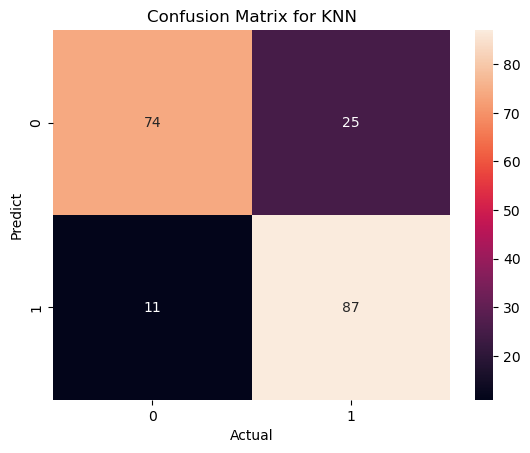

In [27]:
# Membuat visualisasi
plt.figure(dpi = 100)
mat = confusion_matrix(df_test['Sentiment'], y_pred)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=True)

plt.title('Confusion Matrix for KNN')
plt.xlabel('Actual')
plt.ylabel('Predict')
plt.show()

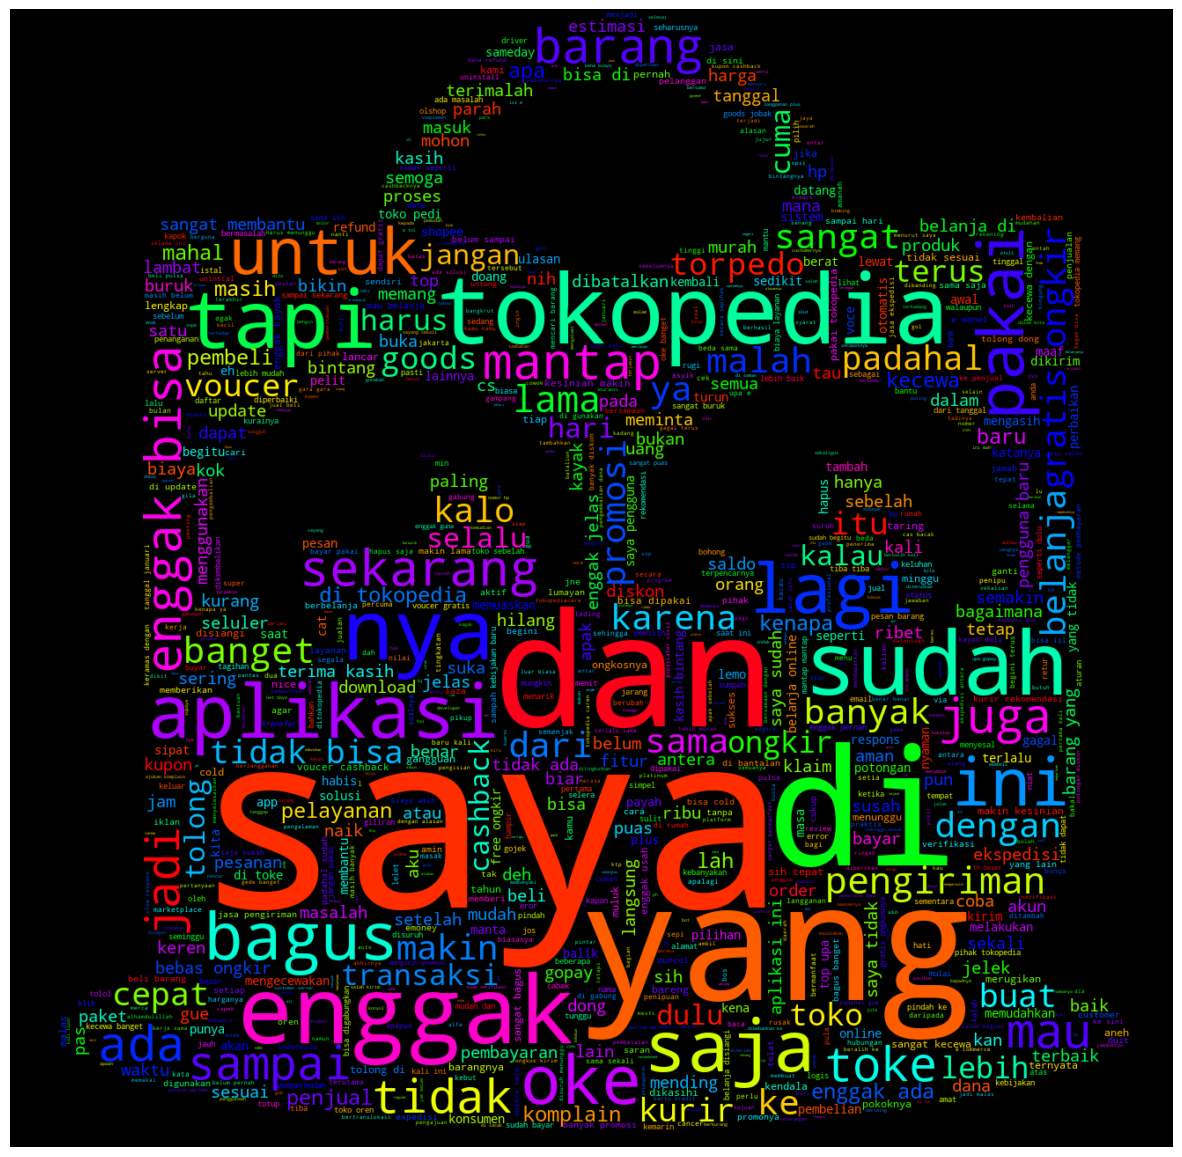

In [28]:
# Word cloud
stopwords = set(STOPWORDS)
mask = np.array(Image.open("tokopedia-logo.png"))
wordcloud = WordCloud(stopwords=stopwords, background_color="black", colormap="gist_rainbow_r", max_words=1000, mask=mask).generate(' '.join(df['Perbaikan kata']))
# Membuat gambar
plt.figure(figsize=[15,15])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()